# Notebook ETL & Análise — Sistema de Administração de Dados para E-commerce
Este notebook é *didático* e comentado. Ele mostra o fluxo ETL (CSV → SQLite DW),
gera KPIs básicos e desenha algumas visualizações simples usando matplotlib.

Arquivos usados estão no diretório atual do projeto.

In [26]:
# Dependências: pandas, sqlite3, matplotlib
import sys
import os
print('Python', sys.version.split('\n')[0])
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Configuração do matplotlib para melhor exibição
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

# Paths - usando caminho relativo para a nova estrutura de pastas
# O notebook está em /notebooks/, o banco está na raiz do projeto
current_dir = os.path.dirname(os.getcwd())  # Sobe um nível do diretório notebooks
db_path = os.path.join(current_dir, "ecommerce_sqlite.db")
print(f"\nDiretório base do projeto: {current_dir}")
print(f"Database path: {db_path}")
print(f"Arquivo existe: {os.path.exists(db_path)}")

# Caminhos para dados CSV (caso necessário)
raw_data_path = os.path.join(current_dir, "data", "raw")
processed_data_path = os.path.join(current_dir, "data", "processed")
print(f"Dados brutos: {raw_data_path}")
print(f"Dados processados: {processed_data_path}")
print(f"Pasta de dados brutos existe: {os.path.exists(raw_data_path)}")
print(f"Pasta de dados processados existe: {os.path.exists(processed_data_path)}")

Python 3.13.4 (tags/v3.13.4:8a526ec, Jun  3 2025, 17:46:04) [MSC v.1943 64 bit (AMD64)]

Diretório base do projeto: d:\Projetos - GIT\Sistema de Administração de Dados para E-commerce
Database path: d:\Projetos - GIT\Sistema de Administração de Dados para E-commerce\ecommerce_sqlite.db
Arquivo existe: True
Dados brutos: d:\Projetos - GIT\Sistema de Administração de Dados para E-commerce\data\raw
Dados processados: d:\Projetos - GIT\Sistema de Administração de Dados para E-commerce\data\processed
Pasta de dados brutos existe: True
Pasta de dados processados existe: True


## Conectar ao banco SQLite e listar tabelas

Abrimos uma conexão e mostramos as tabelas disponíveis para familiarizar.

In [16]:
try:
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    tables = cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    print('Tabelas no SQLite:')
    for t in tables:
        print('-', t[0])
    print(f"\nTotal de tabelas encontradas: {len(tables)}")
except sqlite3.Error as e:
    print(f"Erro ao conectar com o banco de dados: {e}")
    print("Verifique se o arquivo ecommerce_sqlite.db existe no diretório atual.")
except Exception as e:
    print(f"Erro inesperado: {e}")

Tabelas no SQLite:
- stg_cliente
- stg_produto
- stg_pedido
- stg_item_pedido
- dim_tempo
- sqlite_sequence
- dim_cliente
- dim_produto
- fato_vendas

Total de tabelas encontradas: 9


## Pré-visualização das tabelas de staging e DW

Mostramos 5 linhas de cada tabela para entender os dados.

In [17]:
# Lista de tabelas esperadas
tabelas_esperadas = ['stg_cliente', 'stg_produto', 'stg_pedido', 'stg_item_pedido', 
                    'dim_tempo', 'dim_cliente', 'dim_produto', 'fato_vendas']

for tbl in tabelas_esperadas:
    try:
        # Tentativa de detectar colunas de data automaticamente
        query = f"PRAGMA table_info({tbl});"
        colunas_info = pd.read_sql_query(query, conn)
        
        # Identificar possíveis colunas de data
        date_cols = []
        for _, row in colunas_info.iterrows():
            col_name = row['name'].lower()
            if any(word in col_name for word in ['data', 'date', 'cadastro', 'pedido']):
                date_cols.append(row['name'])
        
        # Ler dados da tabela
        df = pd.read_sql_query(f'SELECT * FROM {tbl} LIMIT 5;', conn)
        
        # Tentar converter colunas de data se existirem
        if date_cols:
            for col in date_cols:
                if col in df.columns:
                    try:
                        df[col] = pd.to_datetime(df[col], errors='coerce')
                    except:
                        pass  # Se falhar, mantém como está
        
        print(f'\n--- {tbl} ---')
        print(f'Colunas: {", ".join(df.columns.tolist())}')
        print(f'Registros na amostra: {len(df)}')
        print(df.to_string(index=False))
        
    except Exception as e:
        print(f'\nErro ao ler tabela {tbl}: {e}')


--- stg_cliente ---
Colunas: cliente_id, cpf, nome, email, telefone, data_cadastro, ativo
Registros na amostra: 5
 cliente_id         cpf          nome                       email      telefone data_cadastro  ativo
          1 13113220754   Bruno Gomes   bruno_gomes.1@example.com 5590956713386    2021-09-14      1
          2 74399176163 Rafaela Rocha rafaela_rocha.2@example.com 5583929345267    2024-02-12      0
          3 91518894877  Bruno Santos  bruno_santos.3@example.com 5553953590187    2022-05-21      1
          4  2039949143  Sophia Silva  sophia_silva.4@example.com 5568934661452    2025-06-14      1
          5 67297432402  Carlos Rocha  carlos_rocha.5@example.com 5528980198925    2024-02-14      1

--- stg_produto ---
Colunas: produto_id, nome, categoria, preco, custo, estoque
Registros na amostra: 5
 produto_id              nome   categoria   preco   custo  estoque
          1 Produto 1 - Prime      Livros  940.68  693.18      278
          2  Produto 2 - Beta  Brinquedo

## ETL explicada — como a fato_vendas foi populada
A tabela `fato_vendas` é construída a partir do join entre `stg_pedido` e `stg_item_pedido`.
Abaixo há um exemplo de SQL (compatível com SQLite) que demonstra essa transformação.

In [18]:
etl_sql_exemplo = """
-- ETL: popular fato_vendas (SQLite)
INSERT INTO fato_vendas (
    tempo_id, 
    pedido_id, 
    cliente_id, 
    produto_id, 
    quantidade, 
    valor_unitario, 
    valor_desconto, 
    valor_total, 
    custo_produto
)
SELECT 
    dt.tempo_id,
    p.pedido_id,
    p.cliente_id,
    i.produto_id,
    i.quantidade,
    i.valor_unitario,
    i.desconto,
    (i.quantidade * i.valor_unitario - i.desconto) as valor_total,
    i.custo_produto
FROM stg_pedido p
JOIN stg_item_pedido i ON p.pedido_id = i.pedido_id
JOIN dim_tempo dt ON DATE(p.data_pedido) = DATE(dt.data)
WHERE p.status IN ('completed', 'pending', 'returned', 'cancelled');
"""

print('ETL SQL exemplo para popular fato_vendas:')
print(etl_sql_exemplo)

ETL SQL exemplo para popular fato_vendas:

-- ETL: popular fato_vendas (SQLite)
INSERT INTO fato_vendas (
    tempo_id, 
    pedido_id, 
    cliente_id, 
    produto_id, 
    quantidade, 
    valor_unitario, 
    valor_desconto, 
    valor_total, 
    custo_produto
)
SELECT 
    dt.tempo_id,
    p.pedido_id,
    p.cliente_id,
    i.produto_id,
    i.quantidade,
    i.valor_unitario,
    i.desconto,
    (i.quantidade * i.valor_unitario - i.desconto) as valor_total,
    i.custo_produto
FROM stg_pedido p
JOIN stg_item_pedido i ON p.pedido_id = i.pedido_id
JOIN dim_tempo dt ON DATE(p.data_pedido) = DATE(dt.data)
WHERE p.status IN ('completed', 'pending', 'returned', 'cancelled');



## Cálculo de KPIs — exemplos
1. Faturamento mensal
2. Ticket médio por pedido
3. Número de pedidos por status

As queries abaixo são escritas em SQL e executadas com o SQLite.

In [27]:
# 1) Faturamento mensal (total por ano-mês)
try:
    query = """
    SELECT 
        strftime('%Y-%m', dt.data) AS ano_mes, 
        SUM(f.valor_total) AS faturamento,
        COUNT(DISTINCT f.pedido_id) AS num_pedidos
    FROM fato_vendas f 
    JOIN dim_tempo dt ON f.tempo_id = dt.tempo_id
    GROUP BY ano_mes 
    ORDER BY ano_mes;
    """
    df_fat = pd.read_sql_query(query, conn)
    
    if len(df_fat) > 0:
        print("Faturamento mensal:")
        print(df_fat.to_string(index=False))
    else:
        print("Nenhum dado de faturamento encontrado.")
        
except Exception as e:
    print(f"Erro ao calcular faturamento mensal: {e}")

Faturamento mensal:
ano_mes  faturamento  num_pedidos
2023-01    389119.56           68
2023-02    262286.06           54
2023-03    346420.70           68
2023-04    255635.60           68
2023-05    321300.58           66
2023-06    220322.70           48
2023-07    258920.56           58
2023-08    340135.29           70
2023-09    323318.50           69
2023-10    248572.89           49
2023-11    254927.37           55
2023-12    235447.32           52
2024-01    269304.93           56
2024-02    297644.03           59
2024-03    260213.40           64
2024-04    273826.99           53
2024-05    298160.80           66
2024-06    285319.14           58
2024-07    344690.91           70
2024-08    307576.05           59
2024-09    198593.70           44
2024-10    290452.23           56
2024-11    309696.25           63
2024-12    265263.73           55
2025-01    219342.64           46
2025-02    298450.09           59
2025-03    319951.32           69
2025-04    351897.22        

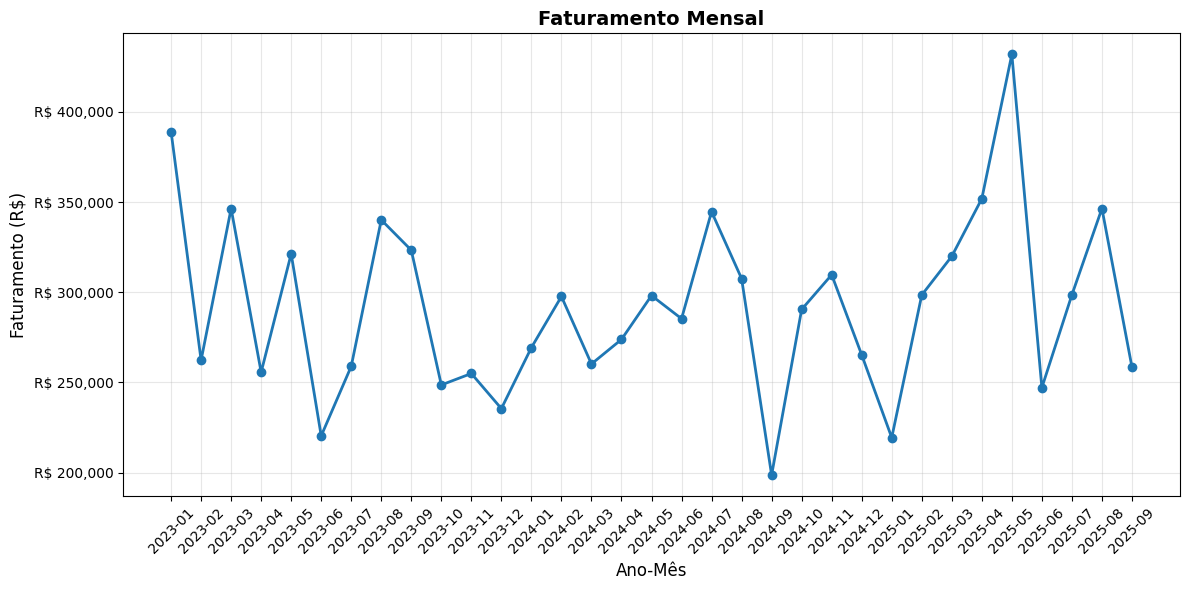

In [20]:
# Plot faturamento mensal (gráfico simples)
try:
    if 'df_fat' in locals() and len(df_fat) > 0:
        plt.figure(figsize=(12, 6))
        plt.plot(df_fat['ano_mes'], df_fat['faturamento'], marker='o', linewidth=2, markersize=6)
        plt.title('Faturamento Mensal', fontsize=14, fontweight='bold')
        plt.xlabel('Ano-Mês', fontsize=12)
        plt.ylabel('Faturamento (R$)', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Formatação dos valores no eixo Y
        ax = plt.gca()
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x:,.0f}'))
        
        plt.tight_layout()
        plt.show()
    else:
        print("Dados de faturamento não disponíveis para gráfico.")
except Exception as e:
    print(f"Erro ao gerar gráfico de faturamento: {e}")

In [21]:
# 2) Ticket médio por pedido
try:
    query2 = """
    SELECT 
        AVG(sub.total_por_pedido) AS ticket_medio,
        COUNT(sub.pedido_id) AS total_pedidos,
        MIN(sub.total_por_pedido) AS menor_pedido,
        MAX(sub.total_por_pedido) AS maior_pedido
    FROM (
        SELECT 
            pedido_id, 
            SUM(valor_total) AS total_por_pedido
        FROM fato_vendas
        GROUP BY pedido_id
    ) sub;
    """
    df_ticket = pd.read_sql_query(query2, conn)
    
    if len(df_ticket) > 0 and df_ticket['ticket_medio'].iloc[0] is not None:
        ticket_medio = float(df_ticket['ticket_medio'].iloc[0])
        total_pedidos = int(df_ticket['total_pedidos'].iloc[0])
        menor_pedido = float(df_ticket['menor_pedido'].iloc[0])
        maior_pedido = float(df_ticket['maior_pedido'].iloc[0])
        
        print(f'Estatísticas de Pedidos:')
        print(f'- Ticket médio: R$ {ticket_medio:,.2f}')
        print(f'- Total de pedidos: {total_pedidos:,}')
        print(f'- Menor pedido: R$ {menor_pedido:,.2f}')
        print(f'- Maior pedido: R$ {maior_pedido:,.2f}')
    else:
        print("Dados de ticket médio não disponíveis.")
        
except Exception as e:
    print(f"Erro ao calcular ticket médio: {e}")

Estatísticas de Pedidos:
- Ticket médio: R$ 4,814.65
- Total de pedidos: 2,000
- Menor pedido: R$ 21.34
- Maior pedido: R$ 26,370.15


In [22]:
# 3) Pedidos por status (stg_pedido)
try:
    q3 = """
    SELECT 
        status, 
        COUNT(*) as qtd,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM stg_pedido), 2) as percentual
    FROM stg_pedido 
    GROUP BY status 
    ORDER BY qtd DESC;
    """
    df_status = pd.read_sql_query(q3, conn)
    
    if len(df_status) > 0:
        print("Distribuição de pedidos por status:")
        print(df_status.to_string(index=False))
    else:
        print("Nenhum dado de status de pedidos encontrado.")
        
except Exception as e:
    print(f"Erro ao consultar status de pedidos: {e}")

Distribuição de pedidos por status:
   status  qtd  percentual
completed 1592        79.6
  pending  230        11.5
cancelled  104         5.2
 returned   74         3.7


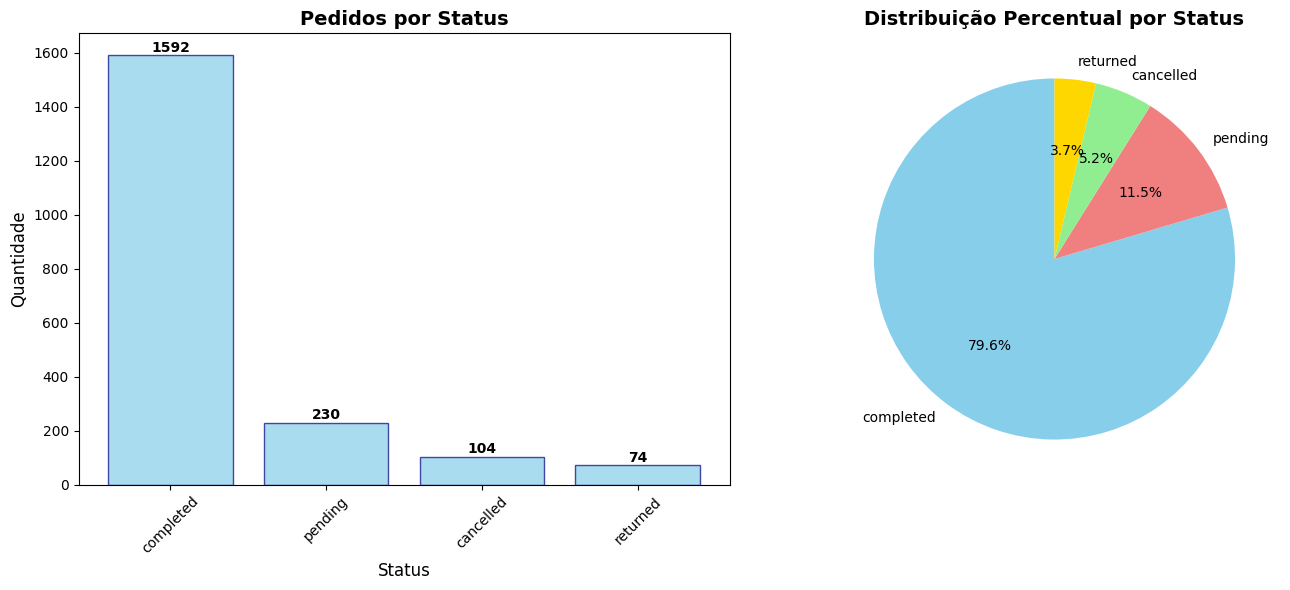

In [23]:
# Plot pedidos por status (barra com percentuais)
try:
    if 'df_status' in locals() and len(df_status) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Gráfico de barras
        bars = ax1.bar(df_status['status'], df_status['qtd'], color='skyblue', edgecolor='navy', alpha=0.7)
        ax1.set_title('Pedidos por Status', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Status', fontsize=12)
        ax1.set_ylabel('Quantidade', fontsize=12)
        ax1.tick_params(axis='x', rotation=45)
        
        # Adicionar valores nas barras
        for bar, qtd in zip(bars, df_status['qtd']):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f'{qtd}', ha='center', va='bottom', fontweight='bold')
        
        # Gráfico de pizza
        ax2.pie(df_status['qtd'], labels=df_status['status'], autopct='%1.1f%%', 
                startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
        ax2.set_title('Distribuição Percentual por Status', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Dados de status não disponíveis para gráfico.")
except Exception as e:
    print(f"Erro ao gerar gráfico de status: {e}")

### Top 10 produtos por quantidade vendida

In [24]:
# Top 10 produtos por quantidade vendida
try:
    q4 = """
    SELECT 
        p.produto_id, 
        p.nome, 
        SUM(f.quantidade) AS total_vendido,
        SUM(f.valor_total) AS receita_total,
        ROUND(AVG(f.valor_unitario), 2) AS preco_medio
    FROM fato_vendas f 
    JOIN dim_produto p ON f.produto_id = p.produto_id
    GROUP BY p.produto_id, p.nome
    ORDER BY total_vendido DESC
    LIMIT 10;
    """
    df_top10 = pd.read_sql_query(q4, conn)
    
    if len(df_top10) > 0:
        print("Top 10 produtos por quantidade vendida:")
        print(df_top10.to_string(index=False))
    else:
        print("Nenhum dado de produtos encontrado.")
        
except Exception as e:
    print(f"Erro ao consultar top 10 produtos: {e}")

Top 10 produtos por quantidade vendida:
 produto_id                nome  total_vendido  receita_total  preco_medio
        163  Produto 163 - Plus             90      146449.90      1692.17
         32   Produto 32 - Plus             85       68333.68       821.57
        173  Produto 173 - Plus             82       55638.71       690.68
        115 Produto 115 - Prime             80      111066.20      1403.72
         19  Produto 19 - Alpha             79       97616.46      1244.37
         93  Produto 93 - Alpha             76       54023.29       713.59
        191 Produto 191 - Prime             75       33727.50       449.70
         39   Produto 39 - Plus             72       79918.14      1123.50
        119 Produto 119 - Alpha             71      122640.94      1743.46
        181  Produto 181 - Plus             71      135937.42      1918.34


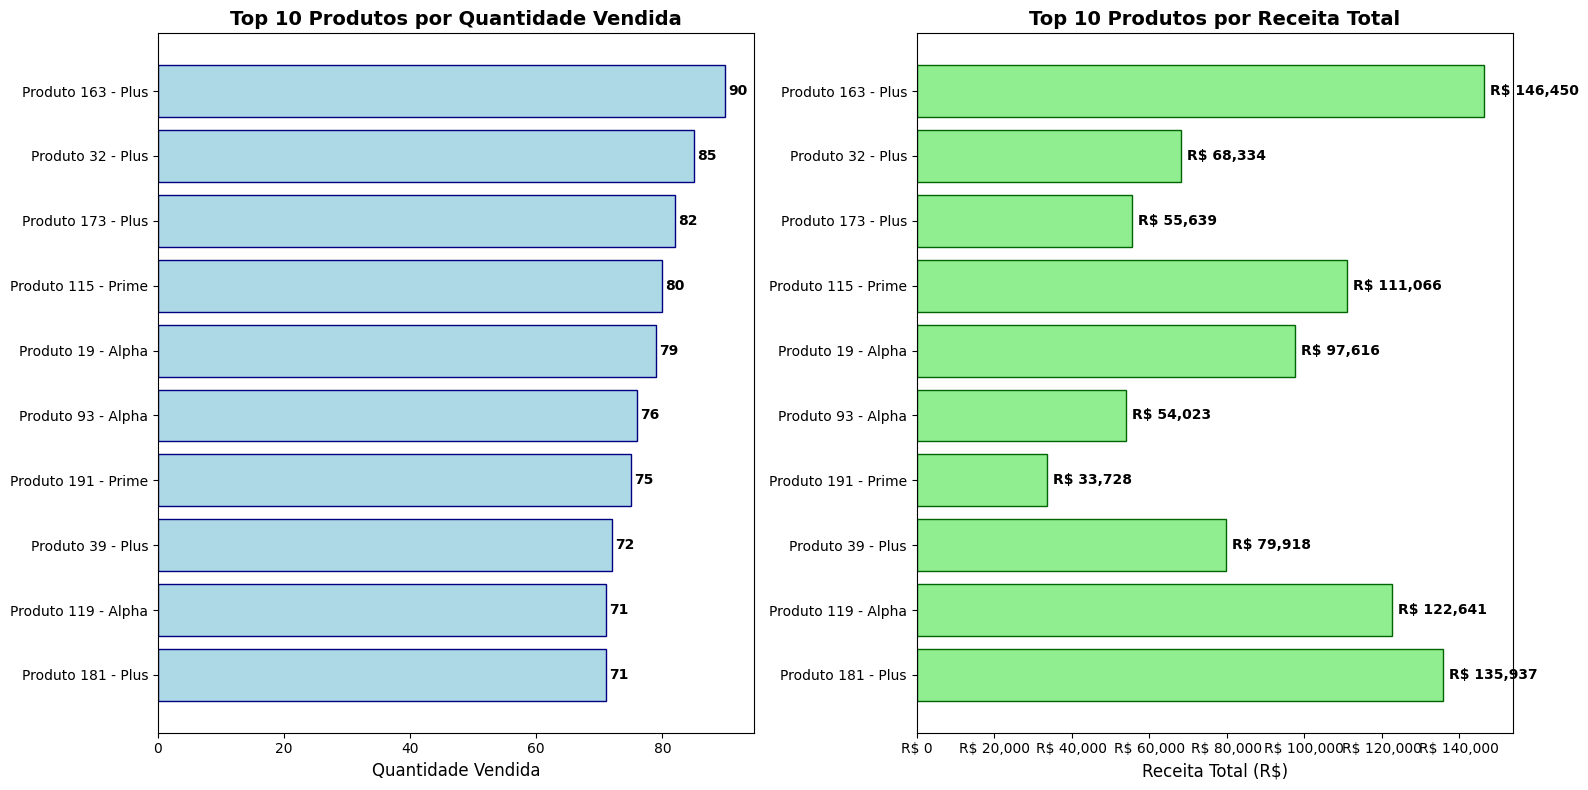

In [25]:
# Plot Top 10 produtos (barra horizontal melhorada)
try:
    if 'df_top10' in locals() and len(df_top10) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Gráfico por quantidade vendida
        bars1 = ax1.barh(df_top10['nome'], df_top10['total_vendido'], color='lightblue', edgecolor='navy')
        ax1.set_title('Top 10 Produtos por Quantidade Vendida', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Quantidade Vendida', fontsize=12)
        ax1.invert_yaxis()  # top first
        
        # Adicionar valores nas barras
        for i, (bar, qtd) in enumerate(zip(bars1, df_top10['total_vendido'])):
            ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                    f'{qtd}', ha='left', va='center', fontweight='bold')
        
        # Gráfico por receita total
        bars2 = ax2.barh(df_top10['nome'], df_top10['receita_total'], color='lightgreen', edgecolor='darkgreen')
        ax2.set_title('Top 10 Produtos por Receita Total', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Receita Total (R$)', fontsize=12)
        ax2.invert_yaxis()  # top first
        
        # Formatação do eixo X para receita
        ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x:,.0f}'))
        
        # Adicionar valores nas barras de receita
        for i, (bar, receita) in enumerate(zip(bars2, df_top10['receita_total'])):
            ax2.text(bar.get_width() + max(df_top10['receita_total'])*0.01, 
                    bar.get_y() + bar.get_height()/2, 
                    f'R$ {receita:,.0f}', ha='left', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Dados de produtos não disponíveis para gráfico.")
except Exception as e:
    print(f"Erro ao gerar gráfico de produtos: {e}")

## Observações finais

### Melhorias implementadas neste notebook:

1. **Correção de caminhos**: Ajustado para usar o diretório atual em vez de caminhos absolutos
2. **Tratamento de erros**: Adicionado try/catch em todas as operações críticas
3. **Visualizações melhoradas**: Gráficos mais informativos com formatação adequada
4. **Métricas expandidas**: Adicionadas estatísticas complementares (percentuais, receita, etc.)
5. **Configuração do matplotlib**: Melhor apresentação visual dos gráficos

### Para executar este notebook:

1. **Dependências necessárias**:
   ```bash
   pip install pandas matplotlib sqlite3
   ```

2. **Estrutura esperada**:
   - Arquivo `ecommerce_sqlite.db` no mesmo diretório
   - Tabelas de staging: `stg_cliente`, `stg_produto`, `stg_pedido`, `stg_item_pedido`
   - Dimensões: `dim_tempo`, `dim_cliente`, `dim_produto`
   - Fato: `fato_vendas`

3. **Execução**:
   - Execute as células sequencialmente
   - Verifique se a conexão com o banco está funcionando
   - Os gráficos serão exibidos automaticamente

### Próximos passos:

- **Migração PostgreSQL**: Adaptar queries SQLite para PostgreSQL usando `DATE_TRUNC`, `TO_CHAR`
- **Dashboard interativo**: Considerar usar Plotly ou Power BI para visualizações dinâmicas
- **Automatização**: Integrar com pipeline de dados automatizado
- **Testes de qualidade**: Implementar validações de dados mais robustas

In [14]:
# Fechar conexão com o banco de dados
try:
    if 'conn' in locals():
        conn.close()
        print("Conexão com o banco de dados fechada com sucesso.")
    else:
        print("Nenhuma conexão ativa encontrada.")
except Exception as e:
    print(f"Erro ao fechar conexão: {e}")

Conexão com o banco de dados fechada com sucesso.
